In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

In [3]:
dataset = load_boston()

dataset.data.shape

(506, 13)

In [4]:
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]#样本数
n_features = X_full.shape[1]#标签数

In [5]:
#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失

rng = np.random.RandomState(0)
#随机数种子

missing_rate = 0.5
#缺失的值的个数
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
#np.floor向下取整，返回.0格式的浮点数

In [6]:
#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，
# 和3289个分布在0~13之间的列索引，那我们就可
#以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0,n_features,n_missing_samples)
#randint(下线，上线，n) 请在下线和上线之间取出n个整数

missing_samples = rng.randint(0,n_samples,n_missing_samples)

In [7]:
#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
'''我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。但如果我们需要
的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中'''

'我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。但如果我们需要\n的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，\n因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中'

In [8]:
len(missing_features)

3289

In [9]:
#把完整的数据拷贝过来
X_missing = X_full.copy()
y_missing = y_full.copy()

#把选中的设置为none空
X_missing[missing_samples,missing_features] = np.nan

X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如
# pandas来得好用

In [10]:
X_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [11]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')#实例化
X_missing_mean = imp_mean.fit_transform(X_missing)#训练fir+导出predict >>> 特殊接口fit_transform
pd.DataFrame(X_missing_mean)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.627579,18.000000,11.163464,0.066007,0.538000,6.305921,65.2,4.090000,1.000000,296.000000,18.521192,352.741952,4.980000
1,0.027310,0.000000,11.163464,0.000000,0.469000,6.305921,78.9,4.967100,2.000000,405.935275,18.521192,396.900000,9.140000
2,0.027290,10.722951,7.070000,0.000000,0.564128,7.185000,61.1,3.856371,2.000000,242.000000,18.521192,352.741952,12.991767
3,3.627579,10.722951,11.163464,0.000000,0.458000,6.305921,45.8,3.856371,9.383871,222.000000,18.700000,352.741952,12.991767
4,3.627579,0.000000,2.180000,0.000000,0.564128,7.147000,67.4,3.856371,9.383871,405.935275,18.700000,352.741952,5.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.627579,10.722951,11.163464,0.000000,0.573000,6.305921,69.1,3.856371,1.000000,405.935275,21.000000,352.741952,9.670000
502,0.045270,0.000000,11.930000,0.000000,0.573000,6.120000,76.7,2.287500,1.000000,273.000000,18.521192,396.900000,9.080000
503,3.627579,10.722951,11.930000,0.066007,0.573000,6.976000,91.0,3.856371,9.383871,405.935275,21.000000,352.741952,5.640000
504,0.109590,0.000000,11.930000,0.066007,0.573000,6.305921,89.3,3.856371,1.000000,405.935275,21.000000,393.450000,6.480000


In [12]:
pd.DataFrame(X_missing_mean).isnull().sum()

#False = 0, True = 1

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [13]:
#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)
pd.DataFrame(X_missing_0)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00000,18.0,0.00,0.0,0.538,0.000,65.2,4.0900,1.0,296.0,0.0,0.00,4.98
1,0.02731,0.0,0.00,0.0,0.469,0.000,78.9,4.9671,2.0,0.0,0.0,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.000,7.185,61.1,0.0000,2.0,242.0,0.0,0.00,0.00
3,0.00000,0.0,0.00,0.0,0.458,0.000,45.8,0.0000,0.0,222.0,18.7,0.00,0.00
4,0.00000,0.0,2.18,0.0,0.000,7.147,0.0,0.0000,0.0,0.0,18.7,0.00,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.00000,0.0,0.00,0.0,0.573,0.000,69.1,0.0000,1.0,0.0,21.0,0.00,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,0.0,396.90,9.08
503,0.00000,0.0,11.93,0.0,0.573,6.976,91.0,0.0000,0.0,0.0,21.0,0.00,5.64
504,0.10959,0.0,11.93,0.0,0.573,0.000,89.3,0.0000,1.0,0.0,21.0,393.45,6.48


In [14]:
'''
使用随机森林回归填补缺失值
任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征
矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数
量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，
用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新
的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部
分，只有特征没有标签，就是我们需要预测的部分。

特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train
特征T不缺失的值：Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test
特征T缺失的值：未知，我们需要预测的Y_test

这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？
答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填
补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当
进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，
而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。
遍历所有的特征后，数据就完整，不再有缺失值了。
'''

'\n使用随机森林回归填补缺失值\n任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征\n矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数\n量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，\n用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。\n\n对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新\n的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_test，这部分数据既有标签也有特征，而它缺失的部\n分，只有特征没有标签，就是我们需要预测的部分。\n\n特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train\n特征T不缺失的值：Y_train\n\n特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test\n特征T缺失的值：未知，我们需要预测的Y_test\n\n这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。\n\n那如果数据中除了特征T之外，其他特征也有缺失值怎么办？\n答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。\n填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填\n补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当\n进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，\n而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。\n遍历所有的特征后，数据就完整，不再有缺失值了。\n'

In [15]:
X_missing_reg = X_missing.copy()

In [16]:
#找出数据集中，缺失值从小到大排列的特征们的顺序
#将索引排序
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values
sortindex
#argsort:返回从小到大排序的顺序所对应的索引

array([ 6, 12,  8,  7,  9,  0,  2,  1,  5,  4,  3, 10, 11], dtype=int64)

In [17]:
for i in sortindex:
    #构建我们的新特征矩阵和新标签 (没有被选中去填充的特征 + 原始标签)和新标签(被选中去填充的特征)
    df = X_missing_reg
    
    #新标签
    fillc = df.iloc[:,i] #切片的方式取出索引为 i 的列
    
    #新特征矩阵 
    #pd.colums 显示列的索引
    #pd.concat 参数：1.[对象1，对象2] 2.axis=1 对象2作为列加在1的后面 =0作为行加在1的下面
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0).fit_transform(df)

    #找出我们的训练集和测试集
    #是被选中要填充的特征中（现在是我们的标签），存在的那些值，非空值
    Ytrain = fillc[fillc.notnull()]

    #是被选中要填充的特征中（现在是我们的标签），不存在的那些值，是空值
    #我们需要的不是Ytest的值，是Ytest所带的标签
    Ytest = fillc[fillc.isnull()]

    #在新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
    Xtrain = df_0[Ytrain.index, :]

    #在新特征矩阵上，被选出来的要填充的特征的空值所对应的记录
    Xtest= df_0[Ytest.index, :]

    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)#实例化
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)#用predict接口将Xtest导入，得到我们的预测结果（回归结果）就是我们要用来填补空值的这些值

    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [18]:
 X_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [19]:
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error', 
cv=5).mean()
    mse.append(scores * -1)

In [20]:
mse #MSE越小越好

[21.571667100368845, 40.848037216676374, 49.626793201980185, 20.13559670023296]

In [21]:
[*zip(["X_full","X_missing_mean","X_missing_0","X_missing_reg"],mse)]

[('X_full', 21.571667100368845),
 ('X_missing_mean', 40.848037216676374),
 ('X_missing_0', 49.626793201980185),
 ('X_missing_reg', 20.13559670023296)]

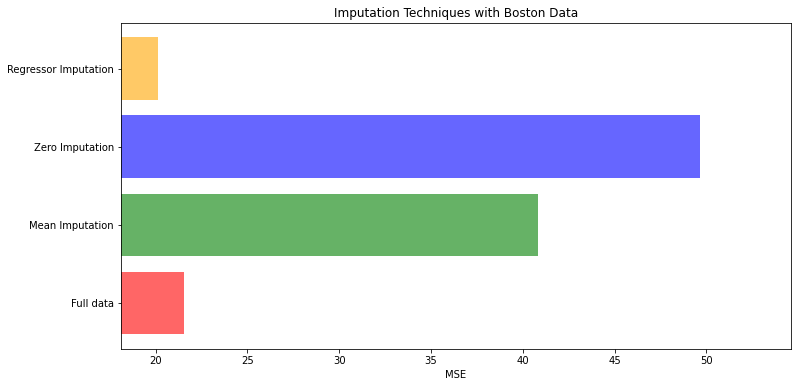

In [26]:
x_labels = ['Full data',
            'Mean Imputation',
            'Zero Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(12, 6)) #画出画布
ax = plt.subplot(111) #添加子图

for i in np.arange(len(mse)):#range(len(mse))
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')
    #bar表示的条形图，h：Horizontal横向的 ax.barh(y,x,color,条的粗度，条放在中间)
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
            right=np.max(mse) * 1.1)#x轴的取值
ax.set_yticks(np.arange(len(mse)))#y轴刻度
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()